In [1]:
from __future__ import print_function

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import binarize

In [3]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
heart = pd.read_csv('CHD_preprocessed.csv')
heart.head()

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39          1              0         0.0     0.0                0   
1     0   46          0              0         0.0     0.0                0   
2     1   48          0              1        20.0     0.0                0   
3     0   61          1              1        30.0     0.0                0   
4     0   46          1              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

In [5]:
heart = heart.dropna()

In [6]:
heart.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [7]:
x = heart.drop('TenYearCHD', axis=1)
y = heart['TenYearCHD']

In [8]:
heart['TenYearCHD'].value_counts()  # the number of affected people 1

0    3505
1     628
Name: TenYearCHD, dtype: int64

In [9]:
#extract the 10 best features
features = SelectKBest(score_func=chi2, k=10)
scores = features.fit(x,y).scores_
columns = x.columns

df = pd.DataFrame()
df['score'] = scores
df['column'] = columns

best_feat = df.sort_values(by='score', ascending=False).head(10)
best_feat

score        column
10  728.028608         sysBP
14  370.026234       glucose
1   318.439180           age
9   233.735513       totChol
4   178.115009    cigsPerDay
11  151.897052         diaBP
7    92.181857  prevalentHyp
8    38.371005      diabetes
5    35.323423        BPMeds
0    16.707199          male

In [10]:
best_features = list(best_feat['column'])

best_features

['sysBP',
 'glucose',
 'age',
 'totChol',
 'cigsPerDay',
 'diaBP',
 'prevalentHyp',
 'diabetes',
 'BPMeds',
 'male']

In [11]:
heart_new = heart[best_features] # reindxing the column 
heart_new['TenYearCHD'] = y

heart_new.head()

<ipython-input-11-2e69d2c5b784>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_new['TenYearCHD'] = y


sysBP  glucose  age  totChol  cigsPerDay  diaBP  prevalentHyp  diabetes  \
0  106.0     77.0   39    195.0         0.0   70.0             0         0   
1  121.0     76.0   46    250.0         0.0   81.0             0         0   
2  127.5     70.0   48    245.0        20.0   80.0             0         0   
3  150.0    103.0   61    225.0        30.0   95.0             1         0   
4  130.0     85.0   46    285.0        23.0   84.0             0         0   

   BPMeds  male  TenYearCHD  
0     0.0     1           0  
1     0.0     0           0  
2     0.0     1           0  
3     0.0     0           1  
4     0.0     0           0

In [12]:
corr = heart_new.corr()

<AxesSubplot:>

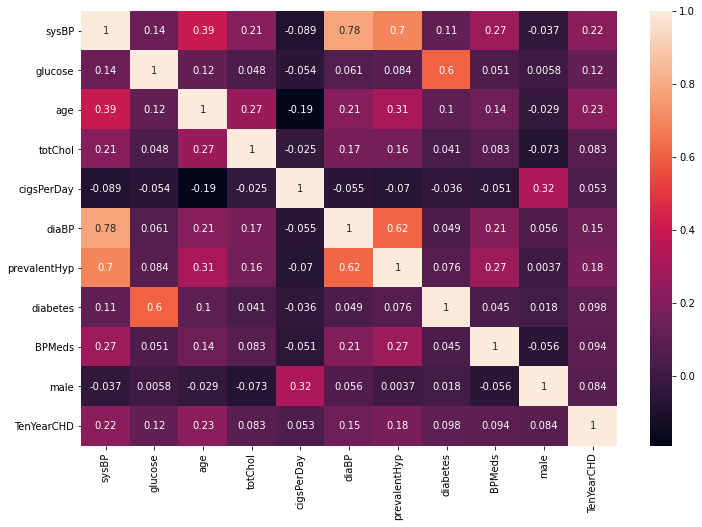

In [13]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr, annot=True)

In [14]:
scaler = MinMaxScaler(feature_range=(0,1)) 

#assign scaler to column:
heart_scaled = pd.DataFrame(scaler.fit_transform(heart_new), columns=heart_new.columns)

heart_scaled.head()

sysBP   glucose       age   totChol  cigsPerDay     diaBP  prevalentHyp  \
0  0.106383  0.104520  0.184211  0.178499    0.000000  0.232804           0.0   
1  0.177305  0.101695  0.368421  0.290061    0.000000  0.349206           0.0   
2  0.208038  0.084746  0.421053  0.279919    0.285714  0.338624           0.0   
3  0.314421  0.177966  0.763158  0.239351    0.428571  0.497354           1.0   
4  0.219858  0.127119  0.368421  0.361055    0.328571  0.380952           0.0   

   diabetes  BPMeds  male  TenYearCHD  
0       0.0     0.0   1.0         0.0  
1       0.0     0.0   0.0         0.0  
2       0.0     0.0   1.0         0.0  
3       0.0     0.0   0.0         1.0  
4       0.0     0.0   0.0         0.0

## Data splitting

In [15]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(heart_scaled, heart_scaled['TenYearCHD']):
    train = heart_scaled.loc[train_index]
    test = heart_scaled.loc[test_index]
    
    x_test = test.drop("TenYearCHD", axis=1)
    y_test = test["TenYearCHD"]

## Sampling

In [16]:
#Separate majority and minority classes
majority = train[train["TenYearCHD"] == 0]
minority = train[train["TenYearCHD"] == 1]

In [17]:
#upsample minority data
minority_upsampled = resample(minority,
                              n_samples =2500,
                              random_state=65)

#combine with mojority dataframe
upsampled = pd.concat([majority, minority_upsampled],axis=0)

In [18]:
#downsample majority data
majority_downsampled = resample(majority,
                                n_samples=511,
                                random_state=65)

downsampled = pd.concat([minority,majority_downsampled],axis=0)

In [19]:
print('Upsampled data: ', '\n', upsampled['TenYearCHD'].value_counts())
print('-----')
print('Downsampled data: ', '\n', downsampled['TenYearCHD'].value_counts())

Upsampled data:  
 0.0    2804
1.0    2500
Name: TenYearCHD, dtype: int64
-----
Downsampled data:  
 0.0    511
1.0    502
Name: TenYearCHD, dtype: int64


In [20]:
print('Initial train set: ', '\n', train['TenYearCHD'].value_counts())

Initial train set:  
 0.0    2804
1.0     502
Name: TenYearCHD, dtype: int64


In [21]:
#splitting dependent and independent variables
downsampled_X = downsampled.drop('TenYearCHD', axis=1)
downsampled_Y = downsampled['TenYearCHD']


upsampled_X = upsampled.drop('TenYearCHD', axis=1)
upsampled_Y = upsampled['TenYearCHD']

## Upsampled data
### Choosing the best hyperparameters

In [22]:
#knn
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2, 3]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(upsampled_X, upsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.9245865757026615
{'algorithm': 'brute', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


In [23]:
#lr
hyperparameters = {
    "max_iter": range(100,200,2),
    "solver" : ['newton-cg', 'lbfgs', 'liblinear'],
    "C": [0.5, 0.1, 1.0]
}

lr = LogisticRegression()
grid = GridSearchCV(lr,param_grid=hyperparameters,cv=10)

grid.fit(upsampled_X, upsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6830661265678855
{'C': 0.5, 'max_iter': 100, 'solver': 'liblinear'}


In [24]:
#randomforest
hyperparameters = {
    "n_estimators": range(100,151,10), 
    "max_depth": [2,3,4,5,7,9],
    'min_samples_split' : [2, 4, 5],
    'min_samples_leaf' :[1,2,3,4,5]
}

clf = RandomForestClassifier()
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(upsampled_X, upsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.8357783463028106
{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 140}


In [25]:
#tree
hyperparameters = {
    "max_depth": [2,4,7,9,10,12,15],
    'min_samples_leaf' :[1,2,3,4,5],
    'max_features' :[2, 4, 6]
}

tree = DecisionTreeClassifier()
grid = GridSearchCV(tree,param_grid=hyperparameters,cv=10)

grid.fit(upsampled_X, upsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.8799033507444125
{'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 1}


 ## Modelling

In [26]:
knn = KNeighborsClassifier(algorithm ='brute', n_neighbors= 1, p= 1, weights ='distance')
lr = LogisticRegression(C=0.5, max_iter = 100, solver = 'liblinear')
tree = DecisionTreeClassifier(max_depth =15, max_features = 6, min_samples_leaf = 1)
clf = RandomForestClassifier(max_depth = 9, min_samples_leaf =1, min_samples_split =2, n_estimators =150)

In [27]:
lr.fit(upsampled_X, upsampled_Y)
knn.fit(upsampled_X, upsampled_Y)
tree.fit(upsampled_X, upsampled_Y)
clf.fit(upsampled_X, upsampled_Y)

RandomForestClassifier(max_depth=9, n_estimators=150)

## Accuracy

In [28]:
print('Logistic Regression: ', accuracy_score(y_test, lr.predict(x_test)))
print('KNN: ', accuracy_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', accuracy_score(y_test, tree.predict(x_test)))
print('Random Forest: ', accuracy_score(y_test, clf.predict(x_test)))

Logistic Regression:  0.7230955259975816
KNN:  0.7678355501813785
Decision Tree:  0.727932285368803
Random Forest:  0.7871825876662636


## Recall

In [29]:
print('Logistic Regression: ', recall_score(y_test, lr.predict(x_test)))
print('KNN: ', recall_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', recall_score(y_test, tree.predict(x_test)))
print('Random Forest: ', recall_score(y_test, clf.predict(x_test)))

Logistic Regression:  0.6031746031746031
KNN:  0.18253968253968253
Decision Tree:  0.31746031746031744
Random Forest:  0.3888888888888889


## Precision

In [30]:
print('Logistic Regression: ', precision_score(y_test, lr.predict(x_test)))
print('KNN: ', precision_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', precision_score(y_test, tree.predict(x_test)))
print('Random Forest: ', precision_score(y_test, clf.predict(x_test)))

Logistic Regression:  0.2980392156862745
KNN:  0.20535714285714285
Decision Tree:  0.22346368715083798
Random Forest:  0.3310810810810811


## F1

In [31]:
print('Logistic Regression: ', f1_score(y_test, lr.predict(x_test)))
print('KNN: ', f1_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', f1_score(y_test, tree.predict(x_test)))
print('Random Forest: ', f1_score(y_test, clf.predict(x_test)))

Logistic Regression:  0.3989501312335958
KNN:  0.19327731092436976
Decision Tree:  0.2622950819672131
Random Forest:  0.35766423357664234


## CONFUSION MATRIX

In [32]:
print('Logistic Regression:\n ', confusion_matrix(y_test, lr.predict(x_test)))
print('---------')
print('KNN: \n', confusion_matrix(y_test, knn.predict(x_test)))
print('---------')
print('Decision Tree: \n', confusion_matrix(y_test, tree.predict(x_test)))
print('---------')
print('Random Forest: \n', confusion_matrix(y_test, clf.predict(x_test)))
print('---------')

Logistic Regression:
  [[522 179]
 [ 50  76]]
---------
KNN: 
 [[612  89]
 [103  23]]
---------
Decision Tree: 
 [[562 139]
 [ 86  40]]
---------
Random Forest: 
 [[602  99]
 [ 77  49]]
---------


## Threshold Tweaking

In [33]:
for i in range(1,6):
    cm2=0
    y_pred_prob_yes=lr.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],
           'False Negatives','\n\n',
          'Recall: ',recall_score(y_test, y_pred2),'\n', 
           'Precision: ',
           precision_score(y_test, y_pred2), '\n', 'AUC is :', roc_auc_score(y_test, y_pred2), '\n',
           'Accuracy is :', accuracy_score(y_test, y_pred2),'\n\n\n')

With 0.1 threshold the Confusion Matrix is  
 [[  0 701]
 [  0 126]] 
 with 126 correct predictions and 0 False Negatives 

 Recall:  1.0 
 Precision:  0.1523579201934704 
 AUC is : 0.5 
 Accuracy is : 0.1523579201934704 



With 0.2 threshold the Confusion Matrix is  
 [[112 589]
 [  2 124]] 
 with 236 correct predictions and 2 False Negatives 

 Recall:  0.9841269841269841 
 Precision:  0.17391304347826086 
 AUC is : 0.571949369381609 
 Accuracy is : 0.28536880290205563 



With 0.3 threshold the Confusion Matrix is  
 [[256 445]
 [ 14 112]] 
 with 368 correct predictions and 14 False Negatives 

 Recall:  0.8888888888888888 
 Precision:  0.20107719928186715 
 AUC is : 0.6270407354572832 
 Accuracy is : 0.4449818621523579 



With 0.4 threshold the Confusion Matrix is  
 [[401 300]
 [ 28  98]] 
 with 499 correct predictions and 28 False Negatives 

 Recall:  0.7777777777777778 
 Precision:  0.24623115577889448 
 AUC is : 0.6749088603582185 
 Accuracy is : 0.6033857315598549 



With 

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.4 as keyword args. From version 1.0

## Downsampled data
### Choosing the best hyperparameters

In [34]:
#knn
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2, 3]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(downsampled_X, downsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6811687051058046
{'algorithm': 'brute', 'n_neighbors': 17, 'p': 3, 'weights': 'distance'}


In [35]:
#lr
hyperparameters = {
    "max_iter": range(100,200,2),
    "solver" : ['newton-cg', 'lbfgs', 'liblinear'],
    "C": [0.5, 0.1, 1.0]
}

lr = LogisticRegression()
grid = GridSearchCV(lr,param_grid=hyperparameters,cv=10)

grid.fit(downsampled_X, downsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.67123859444768
{'C': 0.5, 'max_iter': 100, 'solver': 'liblinear'}


In [36]:
#randomforest
hyperparameters = {
    "n_estimators": range(100,151,10), 
    "max_depth": [2,3,4,5,7,9],
    'min_samples_split' : [2, 4, 5],
    'min_samples_leaf' :[1,2,3,4,5]
}

clf = RandomForestClassifier()
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(downsampled_X, downsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6722869345758105
{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 110}


In [37]:
#tree
hyperparameters = {
    "max_depth": [2,4,7,9,10,12,15],
    'min_samples_leaf' :[1,2,3,4,5],
    'max_features' :[2, 4, 6]
}

tree = DecisionTreeClassifier()
grid = GridSearchCV(tree,param_grid=hyperparameters,cv=10)

grid.fit(downsampled_X, downsampled_Y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_score)
print(best_params)

0.6258396427878081
{'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 5}


## Modeling

In [38]:
knn = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 19, p = 1, weights = 'distance')
lr = LogisticRegression(C= 0.5, max_iter = 100, solver = 'liblinear')
tree = DecisionTreeClassifier(max_depth = 4, max_features = 6, min_samples_leaf =2)
clf = RandomForestClassifier(max_depth =9, min_samples_leaf= 1, min_samples_split =5, n_estimators =110)


lr.fit(downsampled_X, downsampled_Y)
knn.fit(downsampled_X, downsampled_Y)
tree.fit(downsampled_X, downsampled_Y)
clf.fit(downsampled_X, downsampled_Y)

RandomForestClassifier(max_depth=9, min_samples_split=5, n_estimators=110)

## Accuracy

In [39]:
print('Logistic Regression: ', accuracy_score(y_test, lr.predict(x_test)))
print('KNN: ', accuracy_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', accuracy_score(y_test, tree.predict(x_test)))
print('Random Forest: ', accuracy_score(y_test, clf.predict(x_test)))

Logistic Regression:  0.7025392986698912
KNN:  0.6759371221281741
Decision Tree:  0.596130592503023
Random Forest:  0.6517533252720678


## Recall

In [40]:
print('Logistic Regression: ', recall_score(y_test, lr.predict(x_test)))
print('KNN: ', recall_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', recall_score(y_test, tree.predict(x_test)))
print('Random Forest: ', recall_score(y_test, clf.predict(x_test)))

Logistic Regression:  0.626984126984127
KNN:  0.6031746031746031
Decision Tree:  0.7301587301587301
Random Forest:  0.6428571428571429


## Precision

In [41]:
print('Logistic Regression: ', precision_score(y_test, lr.predict(x_test)))
print('KNN: ', precision_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', precision_score(y_test, tree.predict(x_test)))
print('Random Forest: ', precision_score(y_test, clf.predict(x_test)))

Logistic Regression:  0.2841726618705036
KNN:  0.2585034013605442
Decision Tree:  0.23469387755102042
Random Forest:  0.25


## F1

In [42]:
print('Logistic Regression: ', f1_score(y_test, lr.predict(x_test)))
print('KNN: ', f1_score(y_test, knn.predict(x_test)))
print('Decision Tree: ', f1_score(y_test, tree.predict(x_test)))
print('Random Forest: ', f1_score(y_test, clf.predict(x_test)))

Logistic Regression:  0.3910891089108911
KNN:  0.36190476190476195
Decision Tree:  0.3552123552123552
Random Forest:  0.36


## Confusion Matrix

In [43]:
print('Logistic Regression: ', confusion_matrix(y_test, lr.predict(x_test)))
print('---------')
print('KNN: ', confusion_matrix(y_test, knn.predict(x_test)))
print('---------')
print('Decision Tree: ', confusion_matrix(y_test, tree.predict(x_test)))
print('---------')
print('Random Forest: ', confusion_matrix(y_test, clf.predict(x_test)))
print('---------')

Logistic Regression:  [[502 199]
 [ 47  79]]
---------
KNN:  [[483 218]
 [ 50  76]]
---------
Decision Tree:  [[401 300]
 [ 34  92]]
---------
Random Forest:  [[458 243]
 [ 45  81]]
---------


In [44]:
for i in range(1,6):
    cm2=0
    y_pred_prob_yes=lr.predict_proba(x_test)
    y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
            'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],
           'False Negatives','\n\n',
          'Recall: ',recall_score(y_test, y_pred2),'\n', 
           'Precision: ',
           precision_score(y_test, y_pred2), '\n', 'AUC is :', roc_auc_score(y_test, y_pred2), '\n',
           'Accuracy is :', accuracy_score(y_test, y_pred2),'\n\n\n')

With 0.1 threshold the Confusion Matrix is  
 [[  0 701]
 [  0 126]] 
 with 126 correct predictions and 0 False Negatives 

 Recall:  1.0 
 Precision:  0.1523579201934704 
 AUC is : 0.5 
 Accuracy is : 0.1523579201934704 



With 0.2 threshold the Confusion Matrix is  
 [[ 20 681]
 [  0 126]] 
 with 146 correct predictions and 0 False Negatives 

 Recall:  1.0 
 Precision:  0.15613382899628253 
 AUC is : 0.5142653352353781 
 Accuracy is : 0.17654171704957677 



With 0.3 threshold the Confusion Matrix is  
 [[158 543]
 [  2 124]] 
 with 282 correct predictions and 2 False Negatives 

 Recall:  0.9841269841269841 
 Precision:  0.18590704647676162 
 AUC is : 0.6047596404229785 
 Accuracy is : 0.34099153567110035 



With 0.4 threshold the Confusion Matrix is  
 [[326 375]
 [ 21 105]] 
 with 431 correct predictions and 21 False Negatives 

 Recall:  0.8333333333333334 
 Precision:  0.21875 
 AUC is : 0.6491916310033287 
 Accuracy is : 0.5211608222490931 



With 0.5 threshold the Confusio

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass threshold=0.4 as keyword args. From version 1.0

## to conclude 
Logistic regression had the highest recall score of 66.9% with the upsampled data. The recall score can be improved by introducing class-weight parameter in the Logistic Regression Model.

In [46]:
heart1 = pd.read_csv('CHD_preprocessed.csv')
heart.head()

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39          1              0         0.0     0.0                0   
1     0   46          0              0         0.0     0.0                0   
2     1   48          0              1        20.0     0.0                0   
3     0   61          1              1        30.0     0.0                0   
4     0   46          1              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

In [47]:
heart1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4133 entries, 0 to 4132
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4133 non-null   int64  
 1   age              4133 non-null   int64  
 2   education        4133 non-null   int64  
 3   currentSmoker    4133 non-null   int64  
 4   cigsPerDay       4133 non-null   float64
 5   BPMeds           4133 non-null   float64
 6   prevalentStroke  4133 non-null   int64  
 7   prevalentHyp     4133 non-null   int64  
 8   diabetes         4133 non-null   int64  
 9   totChol          4133 non-null   float64
 10  sysBP            4133 non-null   float64
 11  diaBP            4133 non-null   float64
 12  BMI              4133 non-null   float64
 13  heartRate        4133 non-null   float64
 14  glucose          4133 non-null   float64
 15  TenYearCHD       4133 non-null   int64  
dtypes: float64(8), int64(8)
memory usage: 516.8 KB


In [48]:
heart1.shape

(4133, 16)

In [49]:
heart1.describe()

male          age    education  currentSmoker   cigsPerDay  \
count  4133.000000  4133.000000  4133.000000    4133.000000  4133.000000   
mean      0.427293    49.557222     0.280668       0.494798     9.101621   
std       0.494745     8.561628     0.449380       0.500033    11.918440   
min       0.000000    32.000000     0.000000       0.000000     0.000000   
25%       0.000000    42.000000     0.000000       0.000000     0.000000   
50%       0.000000    49.000000     0.000000       0.000000     0.000000   
75%       1.000000    56.000000     1.000000       1.000000    20.000000   
max       1.000000    70.000000     1.000000       1.000000    70.000000   

            BPMeds  prevalentStroke  prevalentHyp     diabetes      totChol  \
count  4133.000000      4133.000000   4133.000000  4133.000000  4133.000000   
mean      0.034358         0.006049      0.311154     0.025647   236.664408   
std       0.182168         0.077548      0.463022     0.158100    43.909188   
min       0.000000         0.000000      0.000000     0.000000   107.000000   
25%       0.000000         0.000000      0.000000     0.000000   206.000000   
50%       0.000000         0.000000      0.000000     0.000000   234.000000   
75%       0.000000         0.000000      1.000000     0.000000   262.000000   
max       1.000000         1.000000      1.000000     1.000000   600.000000   

             sysBP        diaBP          BMI    heartRate      glucose  \
count  4133.000000  4133.000000  4133.000000  4133.000000  4133.000000   
mean    132.367046    82.872248    25.778571    75.925236    81.946528   
std      22.080332    11.952654     4.074360    12.049188    22.860954   
min      83.500000    48.000000    15.540000    44.000000    40.000000   
25%     117.000000    75.000000    23.060000    68.000000    72.000000   
50%     128.000000    82.000000    25.380000    75.000000    80.000000   
75%     144.000000    89.500000    27.990000    83.000000    85.000000   
max     295.000000   142.500000    56.800000   143.000000   394.000000   

        TenYearCHD  
count  4133.000000  
mean      0.151948  
std       0.359014  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [50]:
heart1.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

<AxesSubplot:>

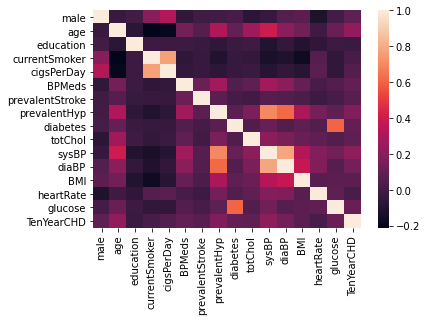

In [51]:
sns.heatmap(heart1.corr())

## Visualize the data
  To see the distribution and also see relationships between features

array([[<AxesSubplot:title={'center':'male'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'currentSmoker'}>],
       [<AxesSubplot:title={'center':'cigsPerDay'}>,
        <AxesSubplot:title={'center':'BPMeds'}>,
        <AxesSubplot:title={'center':'prevalentStroke'}>,
        <AxesSubplot:title={'center':'prevalentHyp'}>],
       [<AxesSubplot:title={'center':'diabetes'}>,
        <AxesSubplot:title={'center':'totChol'}>,
        <AxesSubplot:title={'center':'sysBP'}>,
        <AxesSubplot:title={'center':'diaBP'}>],
       [<AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'heartRate'}>,
        <AxesSubplot:title={'center':'glucose'}>,
        <AxesSubplot:title={'center':'TenYearCHD'}>]], dtype=object)

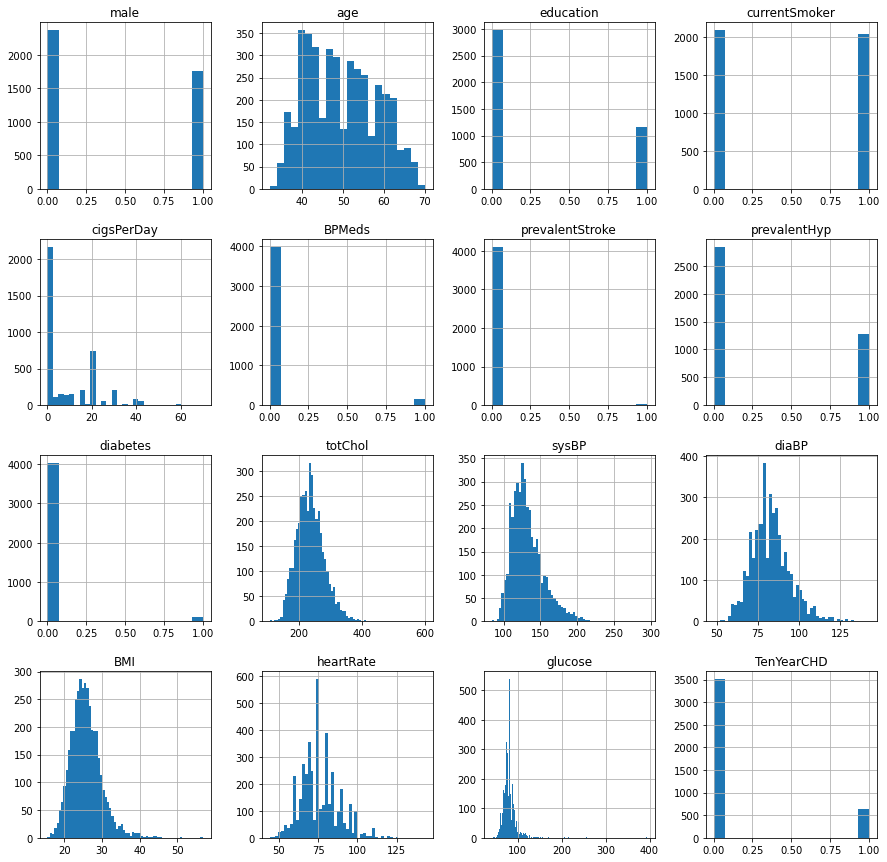

In [52]:
heart1.hist(bins='auto', figsize=(15,15))

### Distribution of heart disease with gender

<AxesSubplot:xlabel='gender', ylabel='count'>

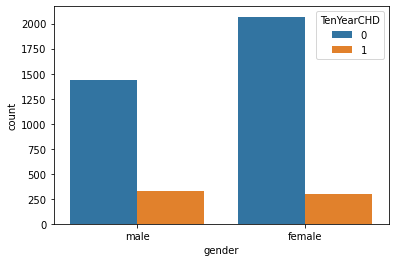

In [53]:
heart_fill_plot = heart1.copy()
heart_fill_plot['male']  = heart_fill_plot['male'].replace({0: 'female', 1:'male'})
heart_fill_plot = heart_fill_plot.rename(columns={'male':'gender'})
sns.countplot(data=heart_fill_plot, x='gender', hue='TenYearCHD')

<AxesSubplot:xlabel='currentSmoker', ylabel='count'>

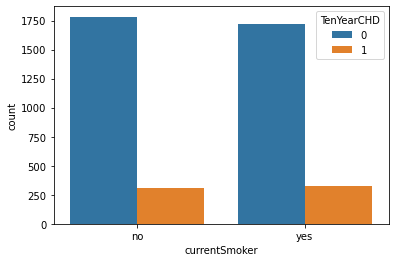

In [54]:
heart_fill_plot['currentSmoker']  = heart_fill_plot['currentSmoker'].replace({0: 'no', 1:'yes'})
sns.countplot(data=heart_fill_plot, x='currentSmoker', hue='TenYearCHD')

<AxesSubplot:xlabel='Age_group', ylabel='count'>

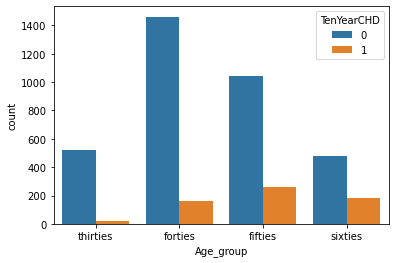

In [55]:
bins= [30,40,50,60,75]
labels = ['thirties','forties','fifties','sixties']

heart_fill_plot['Age_group'] = pd.cut(heart_fill_plot['age'], bins=bins, labels=labels, right=False)

sns.countplot(data=heart_fill_plot, x='Age_group', hue='TenYearCHD')

# Model implementation on full dataset
features-
male-
age-
education-
currentSmoker-
cigsPerDay-
BPMeds-
prevalentStroke-
prevalentHyp-
diabetes-
totChol-
sysBP-
diaBP-
BMI-
heartRate-
glucose-
#### target
TenYearCHD

In [56]:
%run predict_CHD.ipynb # calling the  LogisticRegression module for prediction

In [57]:
predict_80_20(heart1, 'TenYearCHD')

Accuracy score:  0.848851269649335 
 Confusion matrix: 
 [[696   5]
 [120   6]]


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Drop education column

In [58]:
heart_ed = heart1.drop(['education'], axis = 1)

In [59]:
predict_80_20(heart_ed, 'TenYearCHD')

Accuracy score:  0.8464328899637243 
 Confusion matrix: 
 [[696   5]
 [122   4]]


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Drop Glucose

In [60]:
heart_gluc = heart1.drop(['glucose'], axis=1)

In [61]:
predict_80_20(heart_gluc, 'TenYearCHD')

Accuracy score:  0.848851269649335 
 Confusion matrix: 
 [[697   4]
 [121   5]]


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
